# Business Problem:
A group of customers were given an offer in person that they can get a loan at discounted rate and
processing fee will be waived off. A pilot campaign was conducted to get response from customers
whether they are interested in taking out a loan or not. Response was recorded and data was collected.

### Need to Do

- [x] Build a model to predict whether customers will be interested in taking out a loan or not.
- [x] Identifying features which are most important
- [x] In case of black box models e.g. Random forest use SHAP, LIME to figure out features affecting the target variable
- [x] Try Unsupervised clustering models
- [ ] Generate synthetic data for model.
- [x] Approaching a customer has costs involved with it, hence find the profitable segments so that more customized marketing can be done.
- [ ] Need to write inferences what is going on
- [x] Bucketing Age and SCR

Variables involved: `Customer_id`, `Age`, `Gender`, `Balance`, `Occupation`, `No of Credit transaction`, `SCR`, `Holding period`

Bucketed  
Final visualization  
age_d  == 1,2,3,4 vs Target, SCR , _Balance

> ## Understanding Variables


- `Holding Period` (How long the customer is able to hold the money in his account.. So, if they have some existing expenses like a loan EMI or any other monthly expense which gets deducted, usually the first week of every month, hence it makes the balance in the account lower during initial days of the month itself.Higher the holding period, more stable their money is in the account.)

- `SCR` SCR is a score given to a customer for a particular product ( in this case loan ) based on certain parameters, to know whether how likely that customer is to buy that product.. so, higher the score, higher the probability, the customer will buy it.. ###SCR propensity of a customer to respond to a digital marketing


##### Changes v6:
1. Now All Models measure recall on same testing data

2. Fixed Sampling mistake

3. Redefined `print_classification_report` as `classification_report` for better clarity and ease of use

4. Visualized Decision Trees

5. Implemented SVC

6. Implemented KNN which provided great results with default parameters

##### Changes v7:
1. Fit Random Forest Models

2. Fit XgBoost Models

##### Changes v9:
1. Added cross validation

2. Added ROC plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE


import xgboost as xgb

In [2]:
#from pandasgui import show

In [3]:
data = pd.read_csv('Model_data.csv')
#show(data)

In [4]:
data.Balance = data.Balance.astype('int32') #Truncating decimals

In [5]:
data.head()

,Target,Age,Gender,Balance,Occupation,No_OF_CR_TXNS,SCR,Holding_Period
0,0,41,M,91519,SELF-EMP,38,926,15
1,0,52,M,117288,SAL,17,768,13
2,0,31,F,259827,SENP,8,816,5
3,0,45,F,26677,PROF,14,353,18
4,0,39,F,43440,SENP,1,751,31


In [6]:
data.Balance.describe()

count    2.000000e+04
mean     1.461808e+05
std      1.698125e+05
min      0.000000e+00
25%      2.373650e+04
50%      7.975550e+04
75%      2.173100e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [7]:
data.shape

(20000, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          20000 non-null  int64 
 1   Age             20000 non-null  int64 
 2   Gender          20000 non-null  object
 3   Balance         20000 non-null  int32 
 4   Occupation      20000 non-null  object
 5   No_OF_CR_TXNS   20000 non-null  int64 
 6   SCR             20000 non-null  int64 
 7   Holding_Period  20000 non-null  int64 
dtypes: int32(1), int64(5), object(2)
memory usage: 1.1+ MB


`Gender` and `Occupation` are categorical varibles stored as object type

**EDA**

No Strong correlations measured except for mild ones in `Holding_period` and other variables

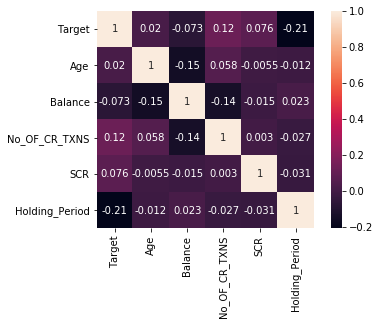

In [9]:
sns.heatmap(data.corr(), annot=True, square=True) # No strong correlations seen overall
plt.show()

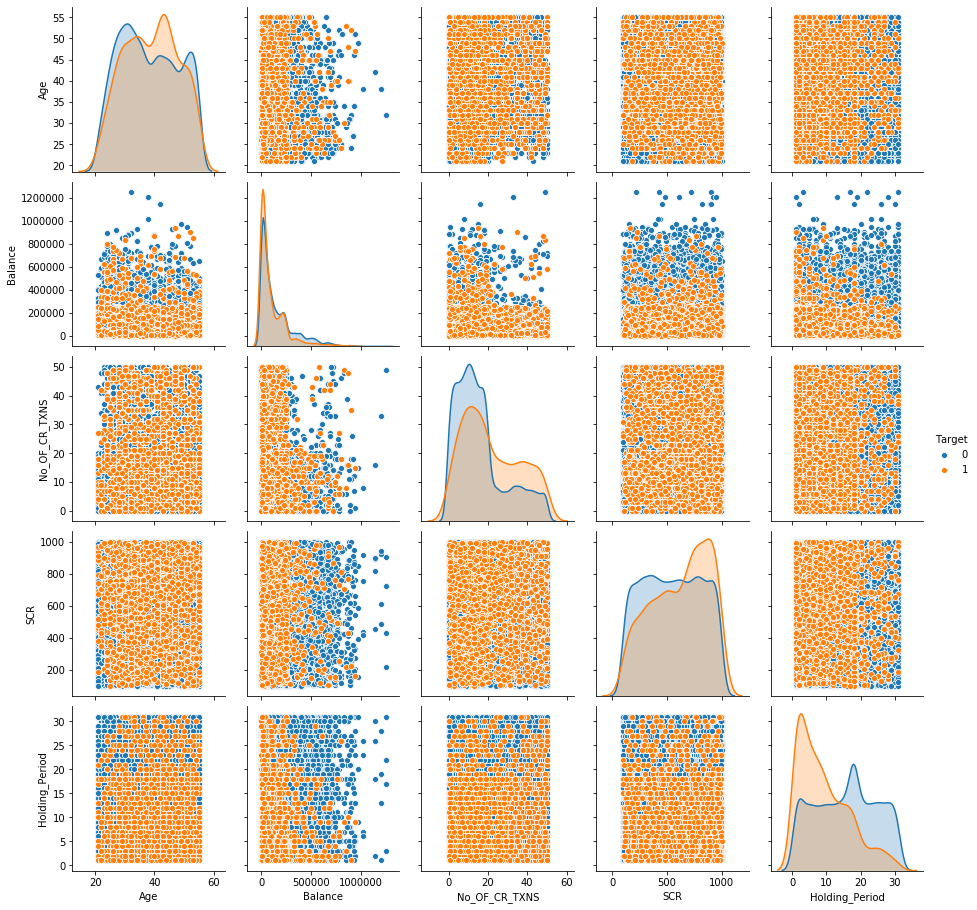

In [10]:
sns.pairplot(data, hue='Target')
plt.show()

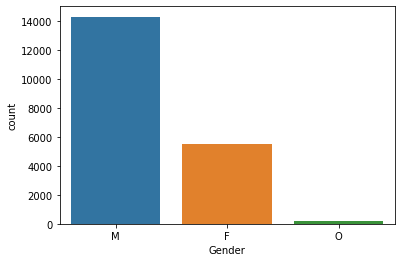

In [11]:
sns.countplot(x = data.Gender)
plt.show()

In [12]:
data.Gender.unique()

array(['M', 'F', 'O'], dtype=object)

In [13]:
data.Occupation.unique()

array(['SELF-EMP', 'SAL', 'SENP', 'PROF'], dtype=object)

In [14]:
data.Gender.value_counts()

M    14279
F     5525
O      196
Name: Gender, dtype: int64

In [15]:
data.drop(data.Gender[data.Gender== 'O'].index, axis = 0, inplace= True) # Removed 196 rows with `Gender` = 'O'

In [16]:
data.shape

(19804, 8)

In [17]:
data.Balance.describe()

count    1.980400e+04
mean     1.465609e+05
std      1.694485e+05
min      0.000000e+00
25%      2.399900e+04
50%      8.035100e+04
75%      2.183090e+05
max      1.246966e+06
Name: Balance, dtype: float64

In [18]:
# sns.histplot(data.Age)

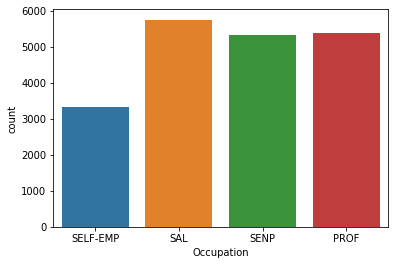

In [19]:
sns.countplot(x = data.Occupation)

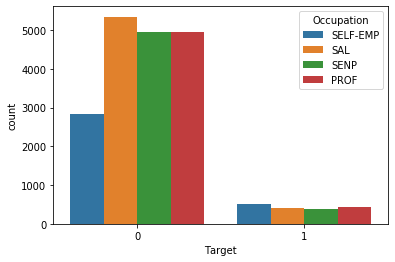

In [20]:
sns.countplot(x=data.Target, hue=data.Occupation) ## Self employed are much more likely to take loans

C:\Users\mazha\anaconda3\Anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


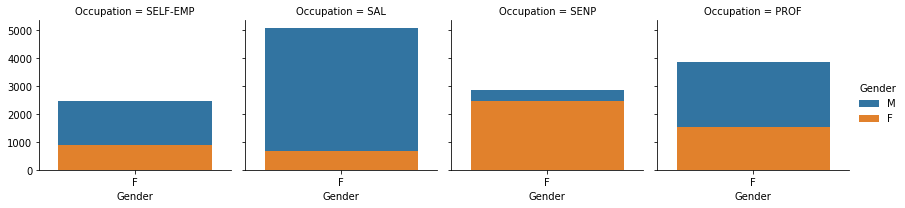

In [21]:
g = sns.FacetGrid(data, col='Occupation', hue="Gender")
plt.grid(True)
g.map(sns.countplot, "Gender", alpha=1)
g.add_legend()
plt.grid((False))

--------------------------

In [22]:
# sns.histplot(data.No_OF_CR_TXNS)

In [23]:
data.No_OF_CR_TXNS.describe()

count    19804.000000
mean        16.563169
std         12.928214
min          0.000000
25%          7.000000
50%         13.000000
75%         21.000000
max         50.000000
Name: No_OF_CR_TXNS, dtype: float64

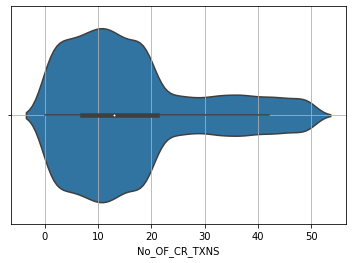

In [24]:
sns.violinplot(x=data.No_OF_CR_TXNS)
plt.grid(True)

In [25]:
# len(data[data.No_OF_CR_TXNS==0].index)

In [26]:
# data.drop(index=data[data.No_OF_CR_TXNS==0].index, axis=0)

------------------

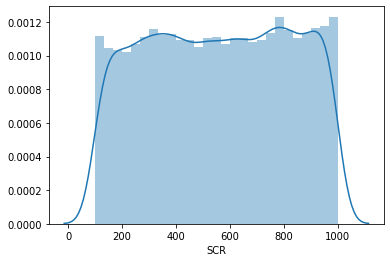

In [27]:
# sns.displot(data.SCR, kind = 'kde')
sns.distplot(data.SCR)
plt.show()

In [28]:
data.SCR.describe()

count    19804.000000
mean       557.115987
std        260.562729
min        100.000000
25%        332.000000
50%        560.500000
75%        784.250000
max        999.000000
Name: SCR, dtype: float64

In [29]:
# sns.histplot(data.Holding_Period)

In [30]:
data3 = data

##### End of Exploratory Data Analysis
-----------
----------

> ### Create a function for easy report printing

In [31]:
# A class for pretty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# function for validation on test data   
def classification_report(y_true, y_prediction, type_of_data='Enter Over/Under/Original sampled', type_of_classifier='ClassifierName'):
    """Print Classification report"""
    
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    
    print('Classification Report on Testing Data:\n'+ color.BOLD + type_of_data, 'data\n'+color.END+color.RED+color.BOLD+type_of_classifier,'Classifier'+color.END+color.END)
    print()
    print('---------------------------------------')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1 score: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print('---------------------------------------')
    print()


# A function for cross-validation report    
def cross_val_report(classifier, train_data, train_label, cv=10, scoring=['recall','precision', 'f1','accuracy']):
    
    score = cross_validate(classifier, train_data, train_label, cv=cv, scoring= scoring)
    recall = np.mean(score['test_recall'])
    precision = np.mean(score['test_precision'])
    f1 = np.mean(score['test_f1'])
    accuracy= np.mean(score['test_accuracy'])
    print('Cross Validation Report')
    print(color.BOLD + 'Recall: %s' %recall + color.END)
    print('Precision: %s' %precision)
    print('F1: %s' %f1)
    print('Accuracy: %s' %accuracy)
    print()
    print("*Mean values presented")
    print('---------------------------------------')

**Create the first set of training and test data on imbalanced data**

In [32]:
df = pd.get_dummies(data, columns=['Gender','Occupation'], drop_first = True)
df.head()

,Target,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,0,41,91519,38,926,15,1,0,1,0
1,0,52,117288,17,768,13,1,1,0,0
2,0,31,259827,8,816,5,0,0,0,1
3,0,45,26677,14,353,18,0,0,0,0
4,0,39,43440,1,751,31,0,0,0,1


>**Creating a model with Original Unbalanced data and measuring metrics**

In [33]:
X_original = df.iloc[:,1:]
y_original = df.iloc[:,0]

In [34]:
X_original

,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,41,91519,38,926,15,1,0,1,0
1,52,117288,17,768,13,1,1,0,0
2,31,259827,8,816,5,0,0,0,1
3,45,26677,14,353,18,0,0,0,0
4,39,43440,1,751,31,0,0,0,1
...,...,...,...,...,...,...,...,...,...
19995,23,67612,20,164,27,0,0,0,1
19996,34,472365,8,124,1,0,0,0,0
19997,42,100642,4,263,1,1,1,0,0
19998,36,29950,10,345,31,1,0,0,1


In [35]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_original,y_original, shuffle = ['True'], stratify=y_original)

Classification Report on Testing Data:
Original data
Decision Tree Classifier

---------------------------------------
Recall: 0.05620608899297424
Precision: 0.4528301886792453
F1 score: 0.1
Accuracy: 0.9127449000201979
---------------------------------------



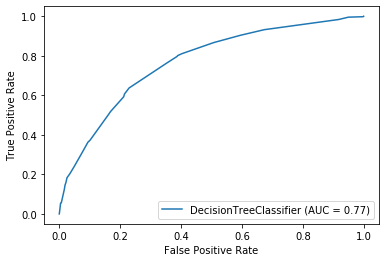

In [87]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train_orig, y_train_orig)
y_prediction_orig = clf.predict(X_test_orig)
classification_report(y_test_orig, y_prediction_orig, 'Original', 'Decision Tree')
plot_roc_curve(clf, X_test_orig, y_test_orig)
plt.show()
# cross_val_report(clf, y_test_orig,y_under_prediction.reshape(1,-1))

In [88]:
from sklearn.metrics import confusion_matrix

In [89]:
confusion_matrix(y_test_orig, y_prediction_orig)

array([[4495,   29],
       [ 403,   24]], dtype=int64)

## High confidence and correct, but low prediction count

-----------

>**Create undersampled data and fit a model**

In [44]:
X_under_train, y_under_train = NearMiss().fit_resample(X_train_orig, y_train_orig)

In [45]:
data[data.Target==1].shape

(1709, 8)

In [46]:
X_under_train.shape, y_under_train.shape

((2564, 9), (2564,))

Classification Report on Testing Data:
Undersampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.7400468384074942
Precision: 0.08893892485223755
F1 score: 0.15879396984924624
Accuracy: 0.323772975156534
---------------------------------------



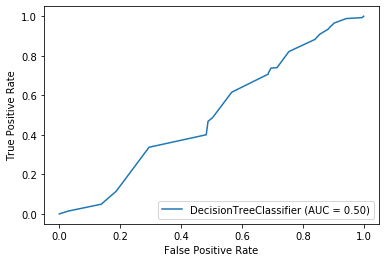

In [85]:
clf_under_sampled = DecisionTreeClassifier(max_depth = 5)
clf_under_sampled.fit(X_under_train, y_under_train)
y_under_prediction = clf_under_sampled.predict(X_test_orig)
classification_report(y_test_orig,y_under_prediction, 'Undersampled', 'Decision Tree')
plot_roc_curve(clf_under_sampled, X_test_orig, y_test_orig)

In [93]:
confusion_matrix(y_test_orig, y_under_prediction)

array([[1287, 3237],
       [ 111,  316]], dtype=int64)

Makes much more predictions, but s = .097

Similar as above

In [48]:
# cross_val_report(clf_under_sampled, y_test_orig,y_under_prediction)

## crossval here causes unbalanced split

In [49]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_under_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

--------------------

> Model on  an oversampled dataset

In [50]:
X_over_train, y_over_train = SMOTE().fit_resample(X_train_orig, y_train_orig)

Classification Report on Testing Data:
Oversampled data
Decision Tree Classifier

---------------------------------------
Recall: 0.468384074941452
Precision: 0.18570102135561745
F1 score: 0.26595744680851063
Accuracy: 0.7770147444960614
---------------------------------------



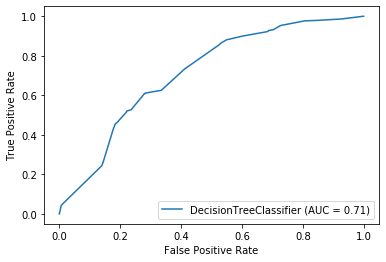

In [90]:
clf_over_sampled = DecisionTreeClassifier(max_depth = 5)
clf_over_sampled.fit(X_over_train, y_over_train)
y_over_predict = clf_over_sampled.predict(X_test_orig)
classification_report(y_test_orig, y_over_predict, 'Oversampled', 'Decision Tree')
plot_roc_curve(clf_over_sampled, X_test_orig, y_test_orig)

In [92]:
confusion_matrix(y_test_orig, y_over_predict)

array([[3647,  877],
       [ 227,  200]], dtype=int64)

In [96]:
s = 0.22805017103762829 ## higher predictions and better confidence

In [52]:
# fig = plt.figure(figsize=(100,100))
# _ = plot_tree(clf_over_sampled, 
#                    feature_names=list(X_original.columns),  
#                    class_names=['0','1'],
#                    filled=True, fontsize=10)

---------------

In [53]:
print("Original:     "+color.BOLD+ "X_original,y_original"+color.END+"::  X_train_orig, X_test_orig, y_train_orig, y_test_orig")
print()
print("Undersampled:"+color.BOLD+ " X_under, y_under"+color.END+"     ::  X_under_train, y_under_train")
print()
print("Oversampled:"+color.BOLD+ "  X_over, y_over"+color.END+"       ::  X_over_train, y_over_train")

Original:     X_original,y_original::  X_train_orig, X_test_orig, y_train_orig, y_test_orig

Undersampled: X_under, y_under     ::  X_under_train, y_under_train

Oversampled:  X_over, y_over       ::  X_over_train, y_over_train


The above datasets can be better sampled by adjusting hyper-parameters of NearMiss and SMOTE, or other methods of sampling could be used

-----------
-----------

### SVM Classifiers applied

*SVC fails to fit on original dataset, possibly because of unbalance*

Classification Report on Testing Data:
Undersampled data
SVM Classifier

---------------------------------------
Recall: 0.5644028103044496
Precision: 0.07749196141479099
F1 score: 0.13627367825841108
Accuracy: 0.3829529388002424
---------------------------------------

Cross Validation Report
Recall: 0.5117005813953488
Precision: 0.8476111226700704
F1: 0.6372839536930555
Accuracy: 0.7090254134241245

*Mean values presented
---------------------------------------


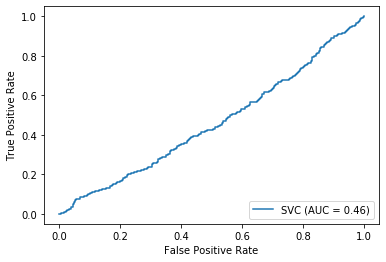

In [54]:
# clf_svc0 = SVC()
# clf_svc0.fit(X_under_train, y_under_train)
# y_predict = clf_svc0.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Undersampled', 'SVM')
# plot_roc_curve(clf_svc0, X_test_orig, y_test_orig)
# cross_val_report(clf_svc0, X_under_train, y_under_train)

In [ ]:
# confusion_matrix(y_test_orig, y_over_predict)

In [55]:
# %%time
# # Will take LONG Time for Training
# clf_svc1 = SVC()
# clf_svc1.fit(X_over_train, y_over_train)
# y_predict = clf_svc1.predict(X_test_orig)
# classification_report(y_test_orig, y_predict, 'Oversampled', 'SVM')
# plot_roc_curve(clf_svc1, X_test_orig, y_test_orig)
# cross_val_report(clf_svc1, X_under_train, y_under_train)

-------------
--------------------

Classification Report on Testing Data:
Original data
KNN Classifier

---------------------------------------
Recall: 0.07259953161592506
Precision: 0.2767857142857143
F1 score: 0.1150278293135436
Accuracy: 0.9036558271056352
---------------------------------------

Cross Validation Report
Recall: 0.6076126453488373
Precision: 0.7087570799369081
F1: 0.6498523733675764
Accuracy: 0.6685493677042802

*Mean values presented
---------------------------------------


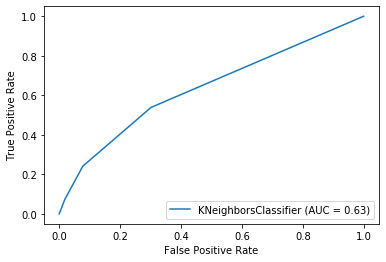

In [56]:
clf_KNN0 = KNeighborsClassifier()
clf_KNN0.fit(X_train_orig, y_train_orig)
y_predict= clf_KNN0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'KNN')
plot_roc_curve(clf_KNN0, X_test_orig, y_test_orig)
cross_val_report(clf_KNN0, X_under_train, y_under_train)

In [97]:
confusion_matrix(y_test_orig, y_predict)

array([[1474, 3050],
       [  78,  349]], dtype=int64)

In [98]:
349/3050

0.11442622950819673

-----------

Classification Report on Testing Data:
Undersampled data
KNN Classifier

---------------------------------------
Recall: 0.7283372365339579
Precision: 0.07960071666240082
F1 score: 0.14351638209506232
Accuracy: 0.25025247424762675
---------------------------------------

Cross Validation Report
Recall: 0.6076126453488373
Precision: 0.7087570799369081
F1: 0.6498523733675764
Accuracy: 0.6685493677042802

*Mean values presented
---------------------------------------


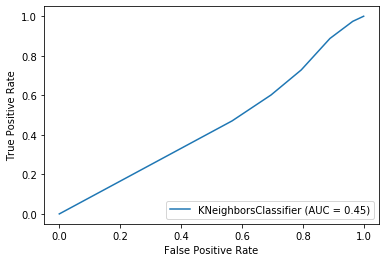

In [99]:
clf_KNN1 = KNeighborsClassifier()
clf_KNN1.fit(X_under_train, y_under_train)
y_predict= clf_KNN1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'KNN')
plot_roc_curve(clf_KNN1, X_test_orig, y_test_orig)
cross_val_report(clf_KNN1, X_under_train, y_under_train)

In [100]:
confusion_matrix(y_test_orig, y_predict)

array([[ 928, 3596],
       [ 116,  311]], dtype=int64)

In [101]:
311/3596

0.08648498331479422

----------
----------

### Random Forest Classifier Models

Classification Report on Testing Data:
Original data
Random Forest Classifier

---------------------------------------
Recall: 0.10304449648711944
Precision: 0.5945945945945946
F1 score: 0.17564870259481039
Accuracy: 0.9165825085841244
---------------------------------------

Cross Validation Report
Recall: 0.7917151162790698
Precision: 0.7938420639533578
F1: 0.7920910291327458
Accuracy: 0.7921069430933853

*Mean values presented
---------------------------------------


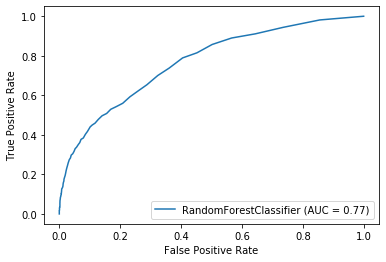

In [58]:
clf_rf0 = RandomForestClassifier()
clf_rf0.fit(X_train_orig, y_train_orig)
y_predict= clf_rf0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Random Forest')
plot_roc_curve(clf_rf0, X_test_orig, y_test_orig)
cross_val_report(clf_rf0, X_under_train, y_under_train)

In [102]:
confusion_matrix(y_test_orig, y_predict)

array([[ 928, 3596],
       [ 116,  311]], dtype=int64)

In [59]:
plot_partial_dependence(clf_rf0, X_test_orig, X_test_orig.columns)

Error in callback <function flush_figures at 0x000001D56BE06B88> (for post_execute):


KeyboardInterrupt: 

-------------

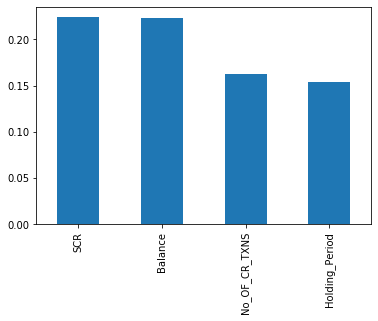

In [60]:
(pd.Series(clf_rf0.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='bar'))

## **RFE Trial**

In [61]:
from sklearn.feature_selection import RFE

In [62]:
rfe = RFE(RandomForestClassifier(), n_features_to_select=4)
rfe = rfe.fit(X_over_train, y_over_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

KeyboardInterrupt: 

In [ ]:
categorical_features_indices = np.where(X_train_orig.dtypes != np.float)[0]

In [ ]:
help(CatBoostClassifier)

In [ ]:
X_train_orig.columns

Classification Report on Testing Data:
Undersampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8266978922716628
Precision: 0.10285547785547786
F1 score: 0.18294895050531226
Accuracy: 0.3631589577863058
---------------------------------------

Cross Validation Report
Recall: 0.7854893410852714
Precision: 0.7948425386203769
F1: 0.7892934806672047
Accuracy: 0.7901553380350195

*Mean values presented
---------------------------------------


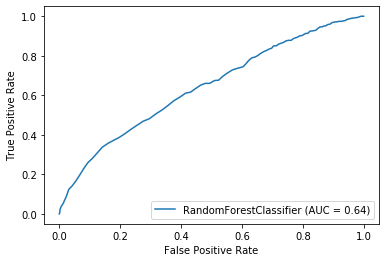

In [81]:
clf_rf1 = RandomForestClassifier()
clf_rf1.fit(X_under_train, y_under_train)
y_predict= clf_rf1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Random Forest')
plot_roc_curve(clf_rf1, X_test_orig, y_test_orig)
cross_val_report(clf_rf1, X_under_train, y_under_train)

-------------

In [82]:
clf_rf2 = RandomForestClassifier()

Classification Report on Testing Data:
Oversampled data
Random Forest Classifier

---------------------------------------
Recall: 0.8173302107728337
Precision: 0.10267725801706384
F1 score: 0.1824359644537376
Accuracy: 0.3682084427388406
---------------------------------------

Cross Validation Report
Recall: 0.7870397286821705
Precision: 0.7984644603163771
F1: 0.7920963236724393
Accuracy: 0.7932727383268483

*Mean values presented
---------------------------------------


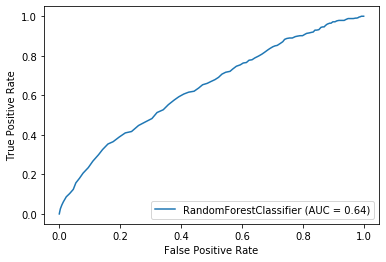

In [83]:
clf_rf2.fit(X_under_train, y_under_train)
y_predict= clf_rf2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Random Forest')
plot_roc_curve(clf_rf2, X_test_orig, y_test_orig)
cross_val_report(clf_rf2, X_under_train, y_under_train)

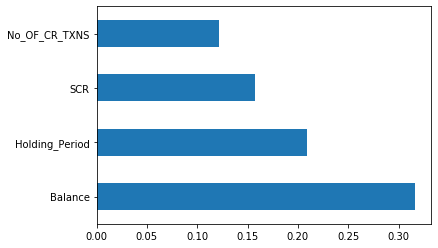

In [84]:
(pd.Series(clf_rf2.feature_importances_, index=X_test_orig.columns)
   .nlargest(4)
   .plot(kind='barh'))

----------
----------------

In [ ]:
# rfe = RFE(KNeighborsClassifier(), n_features_to_select=4)
# rfe = rfe.fit(X_train_orig, y_train_orig)
# # summarize the selection of the attributes
# print(rfe.saupport_)
# print(rfe.ranking_)

------
------

In [ ]:
lr0 = LogisticRegression(max_iter=1000)
lr0.fit(X_train_orig, y_train_orig)
y_predict= lr0.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Original', 'Logistic Regression')
plot_roc_curve(lr0, X_test_orig, y_test_orig)
cross_val_report(lr0, X_under_train, y_under_train)

In [ ]:
lr1 = LogisticRegression(max_iter=100)
lr1.fit(X_under_train, y_under_train)
y_predict= lr1.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Undersampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

In [ ]:
lr2 = LogisticRegression(max_iter=100)
lr2.fit(X_over_train, y_over_train)
y_predict= lr2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'Logistic Regression')
plot_roc_curve(lr1, X_test_orig, y_test_orig)
cross_val_report(lr1, X_under_train, y_under_train)

------
------

In [ ]:
clf_KNN2 = KNeighborsClassifier()
clf_KNN2.fit(X_over_train, y_over_train)
y_predict= clf_KNN2.predict(X_test_orig)
classification_report(y_test_orig, y_predict, 'Oversampled', 'KNN')
plot_roc_curve(clf_KNN2, X_test_orig, y_test_orig)
cross_val_report(clf_KNN2, X_under_train, y_under_train)

**_Segment the customer with prob >90, 80>prob>90, 70>prob>80, 60>prob>70 and so on_**

In [ ]:
predict_prob = clf_KNN2.predict_proba(X_test_orig)
predict_prob.shape
# print more significant digits here

In [ ]:
# predict_prob

In [ ]:
predictions = pd.DataFrame(predict_prob, columns=[0, 'PredictionProb'])

In [ ]:
# predictions.head()

In [ ]:
predictions_prob = predictions.drop(0, axis=1)

In [ ]:
y = pd.DataFrame(y_test_orig, columns = ['Target'])
y = y.reset_index(drop=True)

In [ ]:
error = y.Target- predictions_prob.PredictionProb

In [ ]:
# This series indicate the error, closer to zero values mean better prediction
# positive mean that my model should have predicted loan taker, but did not
# negative means that model should have predicted NOT a loan taker, but did predict as such

In [ ]:
# target - probablity

In [ ]:
plt.hist(error)
plt.xlabel('Error in Prediction: Target - Probablity Of Prediction')
plt.ylabel("Count")
plt.show()

## PRE-BUCKETING VISUALIZATIONS FOR INFERENCES

In [ ]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

In [ ]:
sns.relplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=1.5, kind = "line")
plt.show()

In [ ]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, aspect=2.0, kind = "point")
plt.show()

In [ ]:
sns.catplot(x="Occupation", y="SCR", hue = "Target",data=data, kind = "violin", split = True)
plt.show()

The model is good, make few mistakes

In [ ]:
data1 = data.copy()

## Bucketing for AGE values

In [ ]:
data1['Ageb'] = pd.qcut(data['Age'], q=4)

In [ ]:
data1.head()

In [ ]:
data1.Ageb.value_counts()

In [ ]:
data1.dtypes

In [ ]:
data1.Ageb

In [ ]:
data1.head(5)

In [ ]:
# sns.pairplot(data1, hue='Target')

In [ ]:
data1 = pd.get_dummies(data1)

In [ ]:
data1.head(2)

In [ ]:
data2 = data1.copy()

In [ ]:
data1.columns

In [ ]:
cols = ['Ageb_(30.0, 38.0]', 'Ageb_(20.999, 30.0]','Ageb_(46.0, 55.0]','Ageb_(38.0, 46.0]']

def func1(x):
    if x ==1:
        return 1
def func2(x):
    if x ==1:
        return 2

def func3(x):
    if x ==1:
        return 3

def func4(x):
    if x ==1:
        return 4


data1['age_d'] = data1['Ageb_(30.0, 38.0]'].apply(func1)
data1['age_d'] = data1['Ageb_(20.999, 30.0]'].apply(func2)
data1['age_d'] = data1['Ageb_(46.0, 55.0]'].apply(func3)
data1['age_d'] = data1['Ageb_(38.0, 46.0]'].apply(func4)

In [ ]:
[age] -> [age1,ag2,age3] -> [1,2,3,4]

In [ ]:
for ind, row in data1.iterrows():
    if row['Ageb_(20.999, 30.0]'] ==1:
        data1.loc[ind, 'age_d'] = 1
    elif row['Ageb_(30.0, 38.0]'] ==1:
        data1.loc[ind, 'age_d'] = 2
    elif row['Ageb_(38.0, 46.0]'] ==1:
        data1.loc[ind, 'age_d'] = 3
    elif row['Ageb_(46.0, 55.0]'] ==1:
        data1.loc[ind, 'age_d'] = 4

In [ ]:
data1.age_d.value_counts()

In [ ]:
data1.age_d = data1.age_d.astype('int32')

In [ ]:
data1.head()

## POST-BUCKETING VISUALIZATIONS FOR INFERENCES

In [ ]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

In [ ]:
data1.columns

In [ ]:
sns.scatterplot(x='age_d', y="SCR", hue = "Target",data=data1,)
plt.show()

In [ ]:
sns.catplot(x="age_d", y="SCR", hue = "Target",data=data1, kind = "swarm")
plt.show()

In [ ]:
sns.set_style('ticks')

In [ ]:
g = sns.relplot(x="SCR", y="age_d", hue = "Target",data=data1, aspect=3, kind = "line")
# g.figure.set_size_inches(18.5, 10.5)
# sns.despine()

## BUCKETING SCR & HOLDING PERIODS

In [ ]:
data1['SCRb'] = pd.qcut(data['SCR'], q=5)

In [ ]:
data1.SCRb.value_counts()

In [ ]:
data1['HPB'] = pd.qcut(data['Holding_Period'], q=4)

In [ ]:
data1.HPB.value_counts()

In [ ]:
data1.head()

In [ ]:
sns.catplot(x="age_d", y="SCRb", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

In [ ]:
sns.catplot(x="age_d", y="HPB", hue = "Target",data=data1, kind = "violin", split = True)
plt.show()

In [ ]:
sns.pairplot(data1, hue = 'Target')
plt.show()

## SHAP

In [ ]:
# import shap

In [ ]:
# X_train_summary = shap.kmeans(X_train_orig, 10)

In [ ]:
# explainerKNN = shap.KernelExplainer(clf_KNN0.predict,X_train_summary)

In [ ]:
# shap_values_KNN_test = explainerKNN.shap_values(X_test_orig)

In [ ]:
# shap.initjs()
# shap.force_plot(explainerKNN.expected_value, shap_values_KNN_test[:1000,:], X_test_orig.iloc[:1000,:])

## LIME

In [105]:
# import lime
# import lime.lime_tabular

In [106]:
# lgb_params = {
#   'task': 'train',
#     'boosting_type': 'goss',
#     'objective': 'binary',
#     'metric':'binary_logloss',
#     'metric': {'l2', 'auc'},
#     'num_leaves': 50,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'verbose': None,
#     'num_iteration':100,
#     'num_threads':7,
#     'max_depth':12,
#     'min_data_in_leaf':100,
#     'alpha':0.5}

In [107]:
import warnings
from lime import submodular_pick
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_orig, y_train_orig)
lgb_eval = lgb.Dataset(X_test_orig, y_test_orig)

model = lgb.train(lgb_params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5)
lime.lime_tabular.LimeTabularExplainer(data[model.feature_name()].astype(int).values,  
mode='classification',training_labels=data3['Target'],feature_names=model.feature_name())
# Remember to convert the dataframe to matrix values
# SP-LIME returns exaplanations on a sample set to provide a non redundant global decision boundary of original model
sp_obj = submodular_pick.SubmodularPick(explainer,data3[model.feature_name()].values, \
prob, num_features=5,num_exps_desired=10)

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

Found `num_iteration` in params. Will use it instead of argument


[LightGBM] [Info] Number of positive: 1282, number of negative: 13571
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 14853, number of used features: 9
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086313 -> initscore=-2.359514
[LightGBM] [Info] Start training from score -2.359514
[1]	valid_0's auc: 0.733499	valid_0's l2: 0.0771412
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.774234	valid_0's l2: 0.0757625
[3]	valid_0's auc: 0.774173	valid_0's l2: 0.0746259
[4]	valid_0's auc: 0.778889	valid_0's l2: 0.0736928
[5]	valid_0's auc: 0.778013	valid_0's l2: 0.0730311
[6]	valid_0's auc: 0.776148	valid_0's l2: 0.0723918
[7]	valid_0's auc: 0.780704	valid_0's l2:

KeyError: "['Gender_M', 'Occupation_SELF-EMP', 'Occupation_SENP', 'Occupation_SAL'] not in index"

In [69]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(random_seed=42)

In [65]:
cate_features_index = np.where(data.dtypes != float)[0]

In [71]:
X_over_train

,Age,Balance,No_OF_CR_TXNS,SCR,Holding_Period,Gender_M,Occupation_SAL,Occupation_SELF-EMP,Occupation_SENP
0,48,72332,19,542,25,1,0,0,1
1,30,61736,36,406,13,1,0,0,0
2,34,32944,11,675,17,0,1,0,0
3,32,170978,17,233,2,1,1,0,0
4,53,27769,32,217,22,1,1,0,0
...,...,...,...,...,...,...,...,...,...
27137,44,10835,48,916,13,1,0,0,1
27138,55,190314,20,808,15,1,0,0,0
27139,32,2378,33,446,20,0,0,0,0
27140,32,22952,4,427,7,0,0,0,0


In [77]:
model.fit(X_under_train,y_under_train,cat_features=cate_features_index)

Learning rate set to 0.015401
0:	learn: 0.6855037	total: 33.9ms	remaining: 33.9s
1:	learn: 0.6779278	total: 62.2ms	remaining: 31s
2:	learn: 0.6713258	total: 68.4ms	remaining: 22.7s
3:	learn: 0.6653425	total: 84.3ms	remaining: 21s
4:	learn: 0.6584422	total: 94ms	remaining: 18.7s
5:	learn: 0.6512621	total: 105ms	remaining: 17.3s
6:	learn: 0.6449349	total: 126ms	remaining: 17.9s
7:	learn: 0.6390172	total: 141ms	remaining: 17.5s
8:	learn: 0.6331703	total: 164ms	remaining: 18.1s
9:	learn: 0.6272518	total: 177ms	remaining: 17.6s
10:	learn: 0.6213402	total: 188ms	remaining: 16.9s
11:	learn: 0.6166437	total: 200ms	remaining: 16.4s
12:	learn: 0.6112726	total: 216ms	remaining: 16.4s
13:	learn: 0.6055483	total: 230ms	remaining: 16.2s
14:	learn: 0.6008848	total: 240ms	remaining: 15.8s
15:	learn: 0.5967474	total: 249ms	remaining: 15.3s
16:	learn: 0.5927526	total: 256ms	remaining: 14.8s
17:	learn: 0.5886936	total: 267ms	remaining: 14.6s
18:	learn: 0.5848695	total: 274ms	remaining: 14.1s
19:	learn: 0

166:	learn: 0.4253805	total: 2.45s	remaining: 12.2s
167:	learn: 0.4252646	total: 2.47s	remaining: 12.2s
168:	learn: 0.4250410	total: 2.49s	remaining: 12.2s
169:	learn: 0.4246968	total: 2.5s	remaining: 12.2s
170:	learn: 0.4242800	total: 2.51s	remaining: 12.2s
171:	learn: 0.4240020	total: 2.53s	remaining: 12.2s
172:	learn: 0.4236709	total: 2.55s	remaining: 12.2s
173:	learn: 0.4234613	total: 2.58s	remaining: 12.2s
174:	learn: 0.4232667	total: 2.61s	remaining: 12.3s
175:	learn: 0.4230841	total: 2.64s	remaining: 12.4s
176:	learn: 0.4228532	total: 2.65s	remaining: 12.3s
177:	learn: 0.4223902	total: 2.68s	remaining: 12.4s
178:	learn: 0.4221135	total: 2.69s	remaining: 12.3s
179:	learn: 0.4218338	total: 2.7s	remaining: 12.3s
180:	learn: 0.4215121	total: 2.71s	remaining: 12.3s
181:	learn: 0.4212711	total: 2.73s	remaining: 12.3s
182:	learn: 0.4209995	total: 2.75s	remaining: 12.3s
183:	learn: 0.4206431	total: 2.77s	remaining: 12.3s
184:	learn: 0.4203586	total: 2.79s	remaining: 12.3s
185:	learn: 0.

328:	learn: 0.3882579	total: 5.26s	remaining: 10.7s
329:	learn: 0.3881237	total: 5.28s	remaining: 10.7s
330:	learn: 0.3879353	total: 5.31s	remaining: 10.7s
331:	learn: 0.3877126	total: 5.32s	remaining: 10.7s
332:	learn: 0.3876083	total: 5.34s	remaining: 10.7s
333:	learn: 0.3874633	total: 5.36s	remaining: 10.7s
334:	learn: 0.3872827	total: 5.37s	remaining: 10.7s
335:	learn: 0.3872037	total: 5.39s	remaining: 10.6s
336:	learn: 0.3869651	total: 5.41s	remaining: 10.6s
337:	learn: 0.3869217	total: 5.42s	remaining: 10.6s
338:	learn: 0.3865639	total: 5.44s	remaining: 10.6s
339:	learn: 0.3865638	total: 5.44s	remaining: 10.6s
340:	learn: 0.3863970	total: 5.45s	remaining: 10.5s
341:	learn: 0.3863021	total: 5.46s	remaining: 10.5s
342:	learn: 0.3861652	total: 5.47s	remaining: 10.5s
343:	learn: 0.3859844	total: 5.48s	remaining: 10.4s
344:	learn: 0.3859821	total: 5.48s	remaining: 10.4s
345:	learn: 0.3857418	total: 5.49s	remaining: 10.4s
346:	learn: 0.3855532	total: 5.51s	remaining: 10.4s
347:	learn: 

501:	learn: 0.3623095	total: 8.08s	remaining: 8.02s
502:	learn: 0.3621569	total: 8.1s	remaining: 8s
503:	learn: 0.3620637	total: 8.11s	remaining: 7.98s
504:	learn: 0.3618557	total: 8.14s	remaining: 7.98s
505:	learn: 0.3617429	total: 8.15s	remaining: 7.96s
506:	learn: 0.3615519	total: 8.16s	remaining: 7.94s
507:	learn: 0.3614611	total: 8.18s	remaining: 7.92s
508:	learn: 0.3612887	total: 8.19s	remaining: 7.9s
509:	learn: 0.3611899	total: 8.21s	remaining: 7.89s
510:	learn: 0.3610281	total: 8.23s	remaining: 7.87s
511:	learn: 0.3608835	total: 8.24s	remaining: 7.85s
512:	learn: 0.3606858	total: 8.26s	remaining: 7.84s
513:	learn: 0.3604367	total: 8.28s	remaining: 7.83s
514:	learn: 0.3603043	total: 8.29s	remaining: 7.81s
515:	learn: 0.3601460	total: 8.3s	remaining: 7.79s
516:	learn: 0.3599847	total: 8.31s	remaining: 7.77s
517:	learn: 0.3598232	total: 8.33s	remaining: 7.75s
518:	learn: 0.3596796	total: 8.34s	remaining: 7.73s
519:	learn: 0.3595586	total: 8.35s	remaining: 7.71s
520:	learn: 0.3593

670:	learn: 0.3405602	total: 11s	remaining: 5.38s
671:	learn: 0.3404388	total: 11s	remaining: 5.37s
672:	learn: 0.3402436	total: 11s	remaining: 5.35s
673:	learn: 0.3401162	total: 11s	remaining: 5.34s
674:	learn: 0.3400991	total: 11.1s	remaining: 5.32s
675:	learn: 0.3399262	total: 11.1s	remaining: 5.3s
676:	learn: 0.3397540	total: 11.1s	remaining: 5.29s
677:	learn: 0.3397348	total: 11.1s	remaining: 5.27s
678:	learn: 0.3395907	total: 11.1s	remaining: 5.25s
679:	learn: 0.3394623	total: 11.1s	remaining: 5.24s
680:	learn: 0.3394234	total: 11.1s	remaining: 5.22s
681:	learn: 0.3392536	total: 11.2s	remaining: 5.2s
682:	learn: 0.3390771	total: 11.2s	remaining: 5.19s
683:	learn: 0.3387857	total: 11.2s	remaining: 5.17s
684:	learn: 0.3386212	total: 11.2s	remaining: 5.16s
685:	learn: 0.3383426	total: 11.2s	remaining: 5.14s
686:	learn: 0.3383287	total: 11.2s	remaining: 5.12s
687:	learn: 0.3382222	total: 11.3s	remaining: 5.1s
688:	learn: 0.3379636	total: 11.3s	remaining: 5.09s
689:	learn: 0.3378915	t

836:	learn: 0.3196170	total: 13.5s	remaining: 2.63s
837:	learn: 0.3195751	total: 13.5s	remaining: 2.62s
838:	learn: 0.3194528	total: 13.6s	remaining: 2.6s
839:	learn: 0.3193693	total: 13.6s	remaining: 2.58s
840:	learn: 0.3192990	total: 13.6s	remaining: 2.57s
841:	learn: 0.3191304	total: 13.6s	remaining: 2.55s
842:	learn: 0.3189623	total: 13.6s	remaining: 2.54s
843:	learn: 0.3189012	total: 13.6s	remaining: 2.52s
844:	learn: 0.3188834	total: 13.6s	remaining: 2.5s
845:	learn: 0.3187948	total: 13.6s	remaining: 2.48s
846:	learn: 0.3187130	total: 13.7s	remaining: 2.47s
847:	learn: 0.3185158	total: 13.7s	remaining: 2.45s
848:	learn: 0.3183656	total: 13.7s	remaining: 2.43s
849:	learn: 0.3182369	total: 13.7s	remaining: 2.42s
850:	learn: 0.3180921	total: 13.7s	remaining: 2.4s
851:	learn: 0.3179909	total: 13.7s	remaining: 2.38s
852:	learn: 0.3178133	total: 13.7s	remaining: 2.37s
853:	learn: 0.3175809	total: 13.8s	remaining: 2.35s
854:	learn: 0.3174865	total: 13.8s	remaining: 2.34s
855:	learn: 0.3

In [78]:
test = pd.read_csv("test_data.csv")
pred = model.predict(test)


In [79]:
from sklearn.metrics import confusion_matrix

In [80]:
confusion_matrix(y_test_orig, pred)

array([[1749, 2775],
       [ 175,  252]], dtype=int64)